# NAMA : RIZAL FADLULLAH<br>
# EMAIL : rizal.fadlullah@gmail.com

In [26]:
!wget -q --show-progress --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1gVlyNFK6Nx5zJZc1nEdjU7vg0SaEUJOm' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1gVlyNFK6Nx5zJZc1nEdjU7vg0SaEUJOm" -O dataset.zip && rm -rf /tmp/cookies.txt
!unzip -qq -o dataset.zip
!pip install livelossplot -q --quiet

dataset.zip         100%[===================>]  62.13M   289MB/s    in 0.2s    


In [27]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
import os
import pathlib

In [28]:
img_height = 150
img_width = 150
batch_size = 20

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
  rescale=1./255,
  rotation_range=90,
  horizontal_flip=True, 
  vertical_flip=True,
  validation_split=0.2)

train_generator = datagen.flow_from_directory(
    "dataset/",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
    shuffle=True,
)
val_generator = datagen.flow_from_directory(
    "dataset/",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    shuffle=True,
)

Found 4800 images belonging to 3 classes.
Found 1200 images belonging to 3 classes.


In [29]:
model = tf.keras.models.Sequential([
    tf.keras.applications.ResNet152V2(weights="imagenet", include_top=False, input_tensor=tf.keras.layers.Input(shape=(img_width, img_height, 3))),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2048, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 5, 5, 2048)        58331648  
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 2, 2, 2048)       0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_12 (Dense)            (None, 2048)              16779264  
                                                                 
 dense_13 (Dense)            (None, 512)               1049088   
                                                                 
 dense_14 (Dense)            (None, 256)               131328    
                                                      

In [30]:
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [35]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_loss')<0.20):
      print("\nLoss telah mencapai < 0.2")
      self.model.stop_training = True
callbacks = myCallback()

In [36]:
history = model.fit(
  train_generator,
  epochs=200,
  validation_data=val_generator,
  validation_steps=4,
  callbacks=[callbacks]
)

Epoch 1/200
240/240 [==============================] - 70s 291ms/step - loss: 0.3785 - accuracy: 0.8608 - val_loss: 0.9315 - val_accuracy: 0.7250
Epoch 2/200
240/240 [==============================] - 71s 297ms/step - loss: 0.3606 - accuracy: 0.8679 - val_loss: 0.7059 - val_accuracy: 0.7250
Epoch 3/200
240/240 [==============================] - 72s 299ms/step - loss: 0.3486 - accuracy: 0.8727 - val_loss: 0.4852 - val_accuracy: 0.8250
Epoch 4/200
240/240 [==============================] - 72s 301ms/step - loss: 0.3323 - accuracy: 0.8800 - val_loss: 0.5186 - val_accuracy: 0.8000
Epoch 5/200
240/240 [==============================] - 73s 305ms/step - loss: 0.3270 - accuracy: 0.8815 - val_loss: 1.0999 - val_accuracy: 0.5875
Epoch 6/200
240/240 [==============================] - 73s 304ms/step - loss: 0.3185 - accuracy: 0.8848 - val_loss: 0.4255 - val_accuracy: 0.8750
Epoch 7/200
240/240 [==============================] - 73s 302ms/step - loss: 0.3093 - accuracy: 0.8852 - val_loss: 3.8899 -

In [37]:
test_loss, test_acc = model.evaluate(train_generator)
print ('\nTest accuracy:', test_acc)

240/240 [==============================] - 35s 145ms/step - loss: 0.0998 - accuracy: 0.9652

Test accuracy: 0.9652083516120911


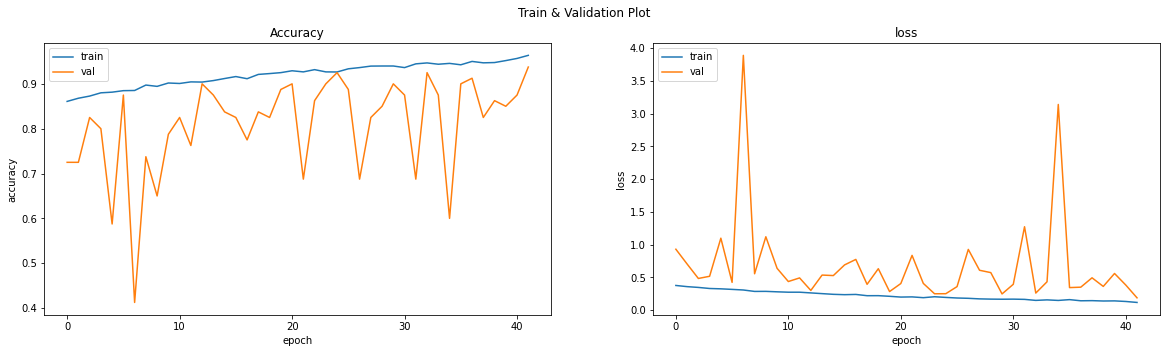

In [38]:
#@title Train & Validation Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Train & Validation Plot')
ax1.set_title('Accuracy')
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')
ax2.set_title('loss')
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.legend(['train', 'val'], loc='upper left')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
plt.show()

In [39]:
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()
 
tflite_model_file = pathlib.Path('fastfood_classification.tflite')
tflite_model_file.write_bytes(tflite_model)

304661316